#Testing AOB mitral cell conversion to NeuroML2#
**The script below runs a single compartment model that includes NaP, Kdr, KA, Cav(R), and leak channels from an AOB mitral cell model that has been converted to .nml from ChannelML in neuroConstruct. The NaT channel is taken from the Examples folder from pyNeuroML. Originally the Migliore NaxSH10 that is in the original ChannelML AOB oitral cell model caused an exception. The BK and Ca_pool from AOB mitral cell model have also been left out as these also provoked exceptions.**

##Update 1: Reinstalled pyNeuroML##

**pyNeuroML has now been re-installed taking into account the use of Anaconda**

**Instead of:**

**sudo python setup.py install**

**sudo ~/anaconda/bin/python setup.py install**

**There are still problems with the Migliore NaxSH10 sodium channel so it has again been left out along with the BK and Ca_pool.**

##Update 2: Migliore Sodium Channel Issue Solved##

**Running with just the leak and Migliore NaxSH10 produces the error: 
pyNeuroML >>> jNeuroML >> Problem while trying to return a value for variable temperature: NaN**

**Padraig's solution:

**The issue was down to the need to use a networkWithTemperature, not network as the main element holding populations, etc. e.g.**

    <network id="net1" type="networkWithTemperature" temperature="32.0 degC"> ... <>

**This needs to be specified in the libNeuroML too to get written correctly:**

    net = nml.Network(id="network", type='networkWithTemperature', temperature='%sdegC'%temperature)

**This temp is what the temp dependent channels see and what sets q10 values etc.**

##Update 3: Calcium pool requires intial Internal and External [Ca2+] to be set##

    <species ion="ca" concentrationModel="Gran_CaPool_98" initialConcentration="7.55E-11 mol_per_cm3" initialExtConcentration="2.4E-6 mol_per_cm3"/>


Populating the interactive namespace from numpy and matplotlib
pyNeuroML >>> Generating Vm(mV) vs Time(ms) plot for cell hhcell in NML2_SingleCompHHCell.nml using jNeuroML
pyNeuroML >>> Including in generated LEMS file: NML2_SingleCompHHCell.nml (/home/Simon/NML2_Test/AOB_mitral_cell/NML2_SingleCompHHCell.nml)
pyNeuroML >>> Including in generated LEMS file: NaxSH10_ChannelML.channel.nml (/home/Simon/NML2_Test/AOB_mitral_cell/NaxSH10_ChannelML.channel.nml)
pyNeuroML >>> Including in generated LEMS file: NaP_iAMC_ChannelML.channel.nml (/home/Simon/NML2_Test/AOB_mitral_cell/NaP_iAMC_ChannelML.channel.nml)
pyNeuroML >>> Including in generated LEMS file: Kdr_iAMC_ChannelML.channel.nml (/home/Simon/NML2_Test/AOB_mitral_cell/Kdr_iAMC_ChannelML.channel.nml)
pyNeuroML >>> Including in generated LEMS file: KA_iAMC_ChannelML.channel.nml (/home/Simon/NML2_Test/AOB_mitral_cell/KA_iAMC_ChannelML.channel.nml)
pyNeuroML >>> Including in generated LEMS file: LeakConductance.channel.nml (/home/Simon/NML

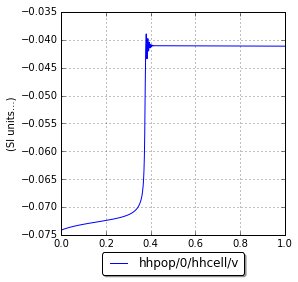

'Volts_file'

In [3]:
%pylab inline
import sys

from pyneuroml import pynml
from pyneuroml.lems.LEMSSimulation import LEMSSimulation
import neuroml as nml

from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import generate_lems_file_for_neuroml

import numpy as np

def generate_Vm_vs_time_plot(NML2_file, 
                                        cell_id, 
                                     #   inj_amp_nA = 80,
                                     #   delay_ms = 20,
                                     #   inj_dur_ms = 0.5,
                                        sim_dur_ms = 1000, 
                                        dt = 0.05,
                                        temperature = "35",
                                        spike_threshold_mV=0.,
                                        plot_voltage_traces=False,
                                        show_plot_already=True, 
                                        simulator="jNeuroML",
                                        include_included=True):
                                            
	# simulation parameters                                            
    nogui = '-nogui' in sys.argv  # Used to supress GUI in tests for Travis-CI
    
    ref = "Test"
    print_comment_v("Generating Vm(mV) vs Time(ms) plot for cell %s in %s using %s"% # (Inj %snA / %sms dur after %sms delay)"%
        (cell_id, NML2_file, simulator))#, inj_amp_nA, inj_dur_ms, delay_ms))
    
    sim_id = 'Vm_%s'%ref
    duration = sim_dur_ms
    ls = LEMSSimulation(sim_id, sim_dur_ms, dt)
    
    ls.include_neuroml2_file(NML2_file, include_included=include_included)
    ls.assign_simulation_target('network')
    nml_doc = nml.NeuroMLDocument(id=cell_id)
    
    nml_doc.includes.append(nml.IncludeType(href=NML2_file))
    
    net = nml.Network(id="network", type='networkWithTemperature', temperature='%sdegC'%temperature)
    nml_doc.networks.append(net)
    
    #input_id = ("input_%s"%str(inj_amp_nA).replace('.','_'))
    #pg = nml.PulseGenerator(id=input_id,
    #                                delay="%sms"%delay_ms,
    #                                duration='%sms'%inj_dur_ms,
    #                                amplitude='%spA'%inj_amp_nA)
    #nml_doc.pulse_generators.append(pg)
    
    
    pop_id = 'hhpop'
    pop = nml.Population(id=pop_id, component='hhcell', size=1, type="populationList")
    
    inst = nml.Instance(id=0)
    pop.instances.append(inst)
    inst.location = nml.Location(x=0, y=0, z=0)
    net.populations.append(pop)
    
    # Add these to cells
    #input_list = nml.InputList(id='il_%s'%input_id,
    #                             component=pg.id,
    #                             populations=pop_id)
    #input = nml.Input(id='0',  target='../hhpop/0/hhcell',
    #                          destination="synapses")  
    
    #input_list.input.append(input)
    #net.input_lists.append(input_list)
    
    sim_file_name = '%s.sim.nml'%sim_id
    pynml.write_neuroml2_file(nml_doc, sim_file_name)
    ls.include_neuroml2_file(sim_file_name)


    disp0 = 'Voltage_display'
    ls.create_display(disp0,"Voltages", "-90", "50")
    ls.add_line_to_display(disp0, "V", "hhpop/0/hhcell/v", scale='1mV')
    
    of0 = 'Volts_file'
    ls.create_output_file(of0, "%s.v.dat"%sim_id)
    ls.add_column_to_output_file(of0, "V", "hhpop/0/hhcell/v")
    
    lems_file_name = ls.save_to_file()
    
    if simulator == "jNeuroML":
        results = pynml.run_lems_with_jneuroml(lems_file_name, 
                                                nogui=True, 
                                                load_saved_data=True, 
                                                plot=plot_voltage_traces,
                                                show_plot_already=False)
    elif simulator == "jNeuroML_NEURON":
        results = pynml.run_lems_with_jneuroml_neuron(lems_file_name, 
                                                nogui=True, 
                                                load_saved_data=True, 
                                                plot=plot_voltage_traces,
                                                show_plot_already=False)
                                                
 
    if show_plot_already:
        from matplotlib import pyplot as plt
        plt.show()
        #plt.plot("t","V")        
        #plt.title("Vm(mV) vs Time(ms) plot for cell %s in %s using %s (Inj %snA / %sms dur after %sms delay)"% 
        #    (cell_id, nml2_file, simulator, inj_amp_nA, inj_dur_ms, delay_ms))
        #plt.xlabel('Time (ms)')
        #plt.ylabel('Vmemb (mV)')
        #plt.legend(['Test'], loc='upper right')
        
        
    return of0     
    

    
generate_Vm_vs_time_plot('NML2_SingleCompHHCell.nml', 'hhcell', plot_voltage_traces =  True)

##NML2 channel Script Validation##
**Padraig sent me a link to a python script containg a 'def' for validating NML2 channels https://github.com/NeuroML/pyNeuroML/blob/master/pyneuroml/pynml.py#L232
Acknowledgment (Thanks to Werner van Geit for an initial version of a python wrapper for jnml.) 
Here I try to use components from that script (without success).** 

In [9]:
import os
import sys
from pyneuroml import pynml
import neuroml as nml

DEFAULTS = {'v':False, 
            'default_java_max_memory':'400M',
            'nogui': False}

def run_jneuroml(pre_args, 
                 target_file, 
                 post_args, 
                 max_memory   = DEFAULTS['default_java_max_memory'], 
                 exec_in_dir  = ".",
                 verbose      = DEFAULTS['v'],
                 exit_on_fail = True):    


    script_dir = os.path.dirname(os.path.realpath(__file__))
    if 'nogui' in post_args:
        pre_jar = " -Djava.awt.headless=true"
    else:
        pre_jar = ""

    jar = os.path.join(script_dir, "lib", 
                       "jNeuroML-%s-jar-with-dependencies.jar" % JNEUROML_VERSION)
    
    output = ''
    
    try:
        output = execute_command_in_dir('java -Xmx%s %s -jar  "%s" %s %s %s' %
                                        (max_memory, pre_jar, jar, pre_args, target_file, 
                                         post_args), exec_in_dir, 
                                        verbose=verbose,
                                        prefix = ' jNeuroML >>  ')
        
    except:
        print_comment('*** Execution of jnml has failed! ***', verbose)
                             
        print_comment(output, verbose)
        if exit_on_fail: 
            sys.exit(-1)
        else:
            return False
        
    
    return True

def validate_neuroml2(nml2_file_name, verbose_validate=True):
    
    pre_args = "-validate"
    post_args = ""
        
    return run_jneuroml(pre_args, 
                 nml2_file_name, 
                 post_args, 
                 verbose = verbose_validate,
                 exit_on_fail = False)
validate_neuroml2("nax.channel.nml") 

NameError: global name '__file__' is not defined

**While here I try the whole script (still without success).**

In [11]:
#Python wrapper around jnml command. 
#Also a number of helper functions for 
#handling/generating/running LEMS/NeuroML2 files

#Thanks to Werner van Geit for an initial version of a python wrapper for jnml.
from __future__ import absolute_import
import os
import sys
import subprocess
import math

from . import __version__
from . import JNEUROML_VERSION

import neuroml
import neuroml.loaders as loaders
import neuroml.writers as writers

import lems.model.model as lems_model

import random
import inspect

DEFAULTS = {'v':False, 
            'default_java_max_memory':'400M',
            'nogui': False}


def parse_arguments():
    """Parse command line arguments"""

    import argparse

    parser = argparse.ArgumentParser(
            description=('pyNeuroML v%s: Python utilities for NeuroML2' % __version__ 
                          + "\n    libNeuroML v%s"%(neuroml.__version__)
                          + "\n    jNeuroML v%s"%JNEUROML_VERSION),
            usage=('pynml [-v|-h|--help] [<shared options>] '
                   '<one of the mutually-exclusive options>'),
            formatter_class=argparse.RawTextHelpFormatter
            )

    shared_options = parser.add_argument_group(
            title='Shared options',
            description=('These options can be added to any of the '
                         'mutually-exclusive options')
            )

    shared_options.add_argument(
            '-verbose',
            action='store_true',
            default=DEFAULTS['v'],
            help='Verbose output'
            )
    shared_options.add_argument(
            '-java_max_memory',
            metavar='MAX',
            default=DEFAULTS['default_java_max_memory'],
            help=('Java memory for jNeuroML, e.g. 400M, 2G (used in\n'
                  '-Xmx argument to java)')
            )
    shared_options.add_argument(
            '-nogui',
            action='store_true',
            default=DEFAULTS['nogui'],
            help=('Suppress GUI,\n'
                  'i.e. show no plots, just save results')
            )
            
    shared_options.add_argument(
            'lems_file',
            type=str,
            metavar='<LEMS/NeuroML 2 file>',
            help='LEMS/NeuroML 2 file to process'
            )
            
    mut_exc_opts_grp = parser.add_argument_group(
            title='Mutually-exclusive options',
            description='Only one of these options can be selected'
            )
    mut_exc_opts = mut_exc_opts_grp.add_mutually_exclusive_group(required=False)
    
    mut_exc_opts.add_argument(
            '-sedml',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert\n'
                  'simulation settings (duration, dt, what to save)\n'
                  'to SED-ML format')
            )
    mut_exc_opts.add_argument(
            '-neuron',
            nargs=argparse.REMAINDER,
            help=('(Via jNeuroML) Load a LEMS file, and convert it to\n'
                  'NEURON format.\n'
                  'The full format of the \'-neuron\' option is:\n'
                  '-neuron [-nogui] [-run] [-outputdir dir] <LEMS file>\n'
                  '    -nogui\n'
                  '        do not generate gtaphical elements in NEURON,\n'
                  '        just run, save data, and quit\n'
                  '    -run\n'
                  '        compile NMODL files and run the main NEURON\n'
                  '        hoc file (Linux only currently)\n'
                  '    -outputdir <dir>\n'
                  '        generate NEURON files in directory <dir>\n'
                  '    <LEMS file>\n'
                  '        the LEMS file to use')
            )
    mut_exc_opts.add_argument(
            '-svg',
            action='store_true',
            help=('(Via jNeuroML) Convert NeuroML2 file (network & cells)\n'
                  'to SVG format view of 3D structure')
            )
    mut_exc_opts.add_argument(
            '-dlems',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to dLEMS format, a distilled form of LEMS in JSON')
            )
    mut_exc_opts.add_argument(
            '-vertex',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to VERTEX format')
            )
    mut_exc_opts.add_argument(
            '-xpp',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to XPPAUT format')
            )
    mut_exc_opts.add_argument(
            '-dnsim',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to DNsim format')
            )
    mut_exc_opts.add_argument(
            '-brian',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to Brian format')
            )
    mut_exc_opts.add_argument(
            '-sbml',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to SBML format')
            )
    mut_exc_opts.add_argument(
            '-matlab',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to MATLAB format')
            )
    mut_exc_opts.add_argument(
            '-cvode',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to C format using CVODE package')
            )
    mut_exc_opts.add_argument(
            '-nineml',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to NineML format')
            )
    mut_exc_opts.add_argument(
            '-spineml',
            action='store_true',
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to SpineML format')
            )
    mut_exc_opts.add_argument(
            '-sbml-import',
            metavar=('<SBML file>', 'duration', 'dt'),
            nargs=3,
            help=('(Via jNeuroML) Load a SBML file, and convert it\n'
                  'toLEMS format using values for duration & dt\n'
                  'in ms (ignoring SBML units)')
            )
    mut_exc_opts.add_argument(
            '-sbml-import-units',
            metavar=('<SBML file>', 'duration', 'dt'),
            nargs=3,
            help=('(Via jNeuroML) Load a SBML file, and convert it\n'
                  'to LEMS format using values for duration & dt\n'
                  'in ms (attempt to extract SBML units; ensure units\n'
                  'are valid in the SBML!)')
            )
    mut_exc_opts.add_argument(
            '-vhdl',
            metavar=('neuronid', '<LEMS file>'),
            nargs=2,
            help=('(Via jNeuroML) Load a LEMS file, and convert it\n'
                  'to VHDL format')
            )
    mut_exc_opts.add_argument(
            '-validate',
            action='store_true',
            help=('(Via jNeuroML) Validate NeuroML2 file(s) against the\n'
                  'latest Schema')
            )
    mut_exc_opts.add_argument(
            '-validatev1',
            action='store_true',
            help=('(Via jNeuroML) Validate NeuroML file(s) against the\n'
                  'v1.8.1 Schema')
            )

    return parser.parse_args()


def validate_neuroml1(nml1_file_name, verbose_validate=True):
    
    pre_args = "-validatev1"
    post_args = ""
        
    return run_jneuroml(pre_args, 
                 nml1_file_name, 
                 post_args,
                 verbose = verbose_validate,
                 exit_on_fail = False)


def validate_neuroml2(nml2_file_name, verbose_validate=True):
    
    pre_args = "-validate"
    post_args = ""
        
    return run_jneuroml(pre_args, 
                 nml2_file_name, 
                 post_args, 
                 verbose = verbose_validate,
                 exit_on_fail = False)
    

def read_neuroml2_file(nml2_file_name, include_includes=False, verbose=False, 
                       already_included=[]):  
    
    print_comment("Loading NeuroML2 file: %s" % nml2_file_name, verbose)
    
    if not os.path.isfile(nml2_file_name):
        print_comment("Unable to find file: %s!" % nml2_file_name, True)
        sys.exit()
        
    nml2_doc = loaders.NeuroMLLoader.load(nml2_file_name)
    base_path = os.path.dirname(os.path.realpath(nml2_file_name))
    
    if include_includes:
        print_comment('Including included files (included already: %s)' \
                      % already_included, verbose)
        
        for include in nml2_doc.includes:
            incl_loc = os.path.abspath(os.path.join(base_path, include.href))
            if incl_loc not in already_included:
                print_comment("Loading included NeuroML2 file: %s (base: %s, resolved: %s)" % (include.href, base_path, incl_loc), 
                              verbose)
                nml2_sub_doc = read_neuroml2_file(incl_loc, True, 
                    verbose=verbose, already_included=already_included)
                already_included.append(incl_loc)
                
                membs = inspect.getmembers(nml2_sub_doc)

                for memb in membs:
                    if isinstance(memb[1], list) and len(memb[1])>0 \
                            and not memb[0].endswith('_'):
                        for entry in memb[1]:
                            if memb[0] != 'includes':
                                print_comment("  Adding %s from: %s to list: %s" \
                                    %(entry, incl_loc, memb[0]))
                                getattr(nml2_doc, memb[0]).append(entry)
                            
        nml2_doc.includes = []
            
    return nml2_doc


def quick_summary(nml2_doc):
    
    info = 'Contents of NeuroML 2 document: %s\n'%nml2_doc.id
    membs = inspect.getmembers(nml2_doc)

    for memb in membs:

        if isinstance(memb[1], list) and len(memb[1])>0 \
                and not memb[0].endswith('_'):
            info+='  %s:\n    ['%memb[0]
            for entry in memb[1]:
                extra = '???'
                extra = entry.id if hasattr(entry,'id') else extra
                extra = entry.href if hasattr(entry,'href') else extra
                
                info+=" %s (%s),"%(entry, extra)
            
            info+=']\n'
    return info


def write_neuroml2_file(nml2_doc, nml2_file_name, validate=True, 
                        verbose_validate=False):
    
    writers.NeuroMLWriter.write(nml2_doc,nml2_file_name)
    
    if validate:
        validate_neuroml2(nml2_file_name, verbose_validate)
        
        
        
def read_lems_file(lems_file_name):
    
    if not os.path.isfile(lems_file_name):
        print_comment("Unable to find file: %s!"%lems_file_name, True)
        sys.exit()
        
    model = lems_model.Model(include_includes=False)

    model.import_from_file(lems_file_name)
    
    return model


def write_lems_file(lems_model, lems_file_name, validate=False):
    
    lems_model.export_to_file(lems_file_name)
    
    if validate:
        from lems.base.util import validate_lems
        validate_lems(lems_file_name)


def relative_path(base_dir, file_name):
    
    if os.path.isabs(file_name): # If the file name is an absolute path...
        return file_name # ... do not prepend the base directory.  
    if base_dir in ['','.','./']: 
        return file_name
    return os.path.join(base_dir,file_name)


def run_lems_with_jneuroml(lems_file_name, 
                           max_memory=DEFAULTS['default_java_max_memory'], 
                           nogui=False, 
                           load_saved_data=False, 
                           plot=False, 
                           show_plot_already=True, 
                           exec_in_dir = ".",
                           verbose=DEFAULTS['v'],
                           exit_on_fail = True):  
                               
    print_comment("Loading LEMS file: %s and running with jNeuroML" \
                  % lems_file_name, verbose)
    post_args = ""
    gui = " -nogui" if nogui else ""
    post_args += gui
    
    success = run_jneuroml("", 
                           lems_file_name, 
                           post_args, 
                           max_memory = max_memory, 
                           exec_in_dir = exec_in_dir, 
                           verbose = verbose, 
                           exit_on_fail = exit_on_fail)
    
    if not success: 
        return False
    
    if load_saved_data:
        return reload_saved_data(relative_path(exec_in_dir,lems_file_name), 
                                 plot=plot, 
                                 show_plot_already=show_plot_already, 
                                 simulator='jNeuroML')
    else:
        return True
    
    

def nml2_to_svg(nml2_file_name, max_memory=DEFAULTS['default_java_max_memory'], 
                verbose=True):           
    print_comment("Converting NeuroML2 file: %s to SVG"%nml2_file_name, verbose)
    
    post_args = "-svg"
    
    run_jneuroml("", 
                 nml2_file_name, 
                 post_args, 
                 max_memory = max_memory, 
                 verbose = verbose)


def run_lems_with_jneuroml_neuron(lems_file_name, 
                                  max_memory=DEFAULTS['default_java_max_memory'], 
                                  nogui=False, 
                                  load_saved_data=False, 
                                  plot=False, 
                                  show_plot_already=True, 
                                  exec_in_dir = ".",
                                  only_generate_scripts = False,
                                  verbose=DEFAULTS['v'],
                                  exit_on_fail = True):
                                      
    print_comment("Loading LEMS file: %s and running with jNeuroML_NEURON" \
                  % lems_file_name, verbose)
                  
    post_args = " -neuron"
    if not only_generate_scripts:
        post_args += ' -run'
    
    gui = " -nogui" if nogui else ""
    post_args += gui
    
    success = run_jneuroml("", 
                           lems_file_name, 
                           post_args, 
                           max_memory = max_memory, 
                           exec_in_dir = exec_in_dir, 
                           verbose = verbose, 
                           exit_on_fail = exit_on_fail)
    
    if not success: 
        return False
    
    if load_saved_data:
        return reload_saved_data(relative_path(exec_in_dir,lems_file_name), 
                                 plot=plot, 
                                 show_plot_already=show_plot_already, 
                                 simulator='jNeuroML_NEURON')
    else:
        return True
    
    
def reload_saved_data(lems_file_name, 
                      plot=False, 
                      show_plot_already=True, 
                      simulator=None, 
                      verbose=DEFAULTS['v']): 
    
    # Could use pylems to parse this...
    results = {}
    
    if plot:
        import matplotlib.pyplot as plt

    base_dir = os.path.dirname(lems_file_name) \
               if len(os.path.dirname(lems_file_name))>0 \
               else '.'
    
    from lxml import etree
    tree = etree.parse(lems_file_name)
    
    sim = tree.getroot().find('Simulation')
    ns_prefix = ''
    
    possible_prefixes = ['{http://www.neuroml.org/lems/0.7.2}']
    if sim is None:
        #print(tree.getroot().nsmap)
        #print(tree.getroot().getchildren())
        for pre in possible_prefixes:
            for comp in tree.getroot().findall(pre+'Component'):
                if comp.attrib['type'] == 'Simulation':
                    ns_prefix = pre
                    sim = comp
    
    output_files = sim.findall(ns_prefix+'OutputFile')
    n_output_files = len(output_files)    
    if plot:
        rows = max(1,math.ceil(n_output_files/3))
        columns = min(3,n_output_files)
        fig,ax = plt.subplots(rows,columns,sharex=True,
                              figsize=(4*columns,4*rows))
        if n_output_files>1:
            ax = ax.ravel()
    
    for i,of in enumerate(output_files):
        results['t'] = []
        file_name = base_dir + '/' + of.attrib['fileName']
        print_comment("Loading saved data from %s%s" \
                      % (file_name, ' (%s)'%simulator if simulator else ''), 
                         verbose)

        cols = []
        cols.append('t')
        for col in of.findall(ns_prefix+'OutputColumn'):
            quantity = col.attrib['quantity']
            results[quantity] = []
            cols.append(quantity)
            
        for line in open(file_name):
            values = line.split()
            
            for vi in range(len(values)):
               results[cols[vi]].append(float(values[vi]))
               

        if plot:
            info = "Data loaded from %s%s" \
                                        % (file_name, ' (%s)' % simulator 
                                                      if simulator else '')
            print_comment_v("Reloading: %s"%info)
            fig.canvas.set_window_title(info)
            
            legend = False
            for key in cols:
                if n_output_files>1:
                    ax_ = ax[i]
                else:
                    ax_ = ax
                ax_.set_xlabel('Time (ms)')
                ax_.set_ylabel('(SI units...)')
                ax_.xaxis.grid(True)
                ax_.yaxis.grid(True)

                if key != 't':
                    ax_.plot(results['t'], results[key], label=key)
                    print_comment("Adding trace for: %s, from: %s" \
                                  % (key,file_name), verbose)
                    ax_.used = True
                    legend = True
                
                if legend:
                    if n_output_files>1:
                        ax_.legend(loc='upper right', fancybox=True, shadow=True, 
                                     ncol=4)#, bbox_to_anchor=(0.5, -0.05))
                    else:
                        ax_.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=4) 
                   
    #print(results.keys())
        
    if plot and show_plot_already:
        
        if n_output_files>1:
            ax_ = ax
        else:
            ax_ = [ax]
        for axi in ax_:
            if not hasattr(axi,'used') or not axi.used:
                axi.axis('off')
        plt.tight_layout()
        plt.show()
        
    return results
               
                        
def get_next_hex_color():
    
    return "#%06x" % random.randint(0,0xFFFFFF)

def evaluate_arguments(args):

    global DEFAULTS
    DEFAULTS['v'] = args.verbose

    pre_args = ""
    files = ""
    post_args = ""
    exit_on_fail = True
    
    files = args.lems_file
        
    if args.nogui:
        post_args = "-nogui"
        
    if args.sedml:
        post_args = "-sedml"
    elif args.neuron is not None:
        num_neuron_args = len(args.neuron)
        if num_neuron_args < 0 or num_neuron_args > 4:
            print("ERROR: The \'-neuron\' option was given an invalid "
                  "number of arguments: %d given, 0-4 required"
                  % num_neuron_args)
            sys.exit(-1)
        post_args = "-neuron %s" % ' '.join(args.neuron[:-1])
    elif args.svg:
        post_args = "-svg"
    elif args.dlems:
        post_args = "-dlems"
    elif args.vertex:
        post_args = "-vertex"
    elif args.xpp:
        post_args = "-xpp"
    elif args.dnsim:
        post_args = "-dnsim"
    elif args.brian:
        post_args = "-brian"
    elif args.sbml:
        post_args = "-sbml"
    elif args.matlab:
        post_args = "-matlab"
    elif args.cvode:
        post_args = "-cvode"
    elif args.nineml:
        post_args = "-nineml"
    elif args.spineml:
        post_args = "-spineml"
    elif args.sbml_import:
        pre_args = "-sbml-import"
        files = args.sbml_import[0]
        post_args = ' '.join(args.sbml_import[1:])
    elif args.sbml_import_units:
        pre_args = "-smbl-import-units"
        files = args.sbml_import_units[0]
        post_args = ' '.join(args.sbml_import_units[1:])
    elif args.vhdl:
        files = args.vhdl[1]
        post_args = "-vhdl %s" % args.vhdl[0]
    elif args.validate:
        pre_args = "-validate"
        exit_on_fail = False
    elif args.validatev1:
        pre_args = "-validatev1"
        exit_on_fail = False
        

    run_jneuroml(pre_args,
                 files,
                 post_args,
                 max_memory = args.java_max_memory,
                 exit_on_fail = exit_on_fail)


def run_jneuroml(pre_args, 
                 target_file, 
                 post_args, 
                 max_memory   = DEFAULTS['default_java_max_memory'], 
                 exec_in_dir  = ".",
                 verbose      = DEFAULTS['v'],
                 exit_on_fail = True):    


    script_dir = os.path.dirname(os.path.realpath(__file__))
    if 'nogui' in post_args:
        pre_jar = " -Djava.awt.headless=true"
    else:
        pre_jar = ""

    jar = os.path.join(script_dir, "lib", 
                       "jNeuroML-%s-jar-with-dependencies.jar" % JNEUROML_VERSION)
    
    output = ''
    
    try:
        output = execute_command_in_dir('java -Xmx%s %s -jar  "%s" %s %s %s' %
                                        (max_memory, pre_jar, jar, pre_args, target_file, 
                                         post_args), exec_in_dir, 
                                        verbose=verbose,
                                        prefix = ' jNeuroML >>  ')
        
    except:
        print_comment('*** Execution of jnml has failed! ***', verbose)
                             
        print_comment(output, verbose)
        if exit_on_fail: 
            sys.exit(-1)
        else:
            return False
        
    
    return True

    
def print_comment_v(text):
    print_comment(text, True)
    
    
def print_comment(text, print_it=DEFAULTS['v']):
    prefix = "pyNeuroML >>> "
    if not isinstance(text, str): text = text.decode('ascii')
    if print_it:
        
        print("%s%s"%(prefix, text.replace("\n", "\n"+prefix)))


def execute_command_in_dir(command, directory, verbose=DEFAULTS['v'], prefix="Output: "):
    
    """Execute a command in specific working directory"""
    
    if os.name == 'nt':
        directory = os.path.normpath(directory)
        
    print_comment_v("Executing: (%s) in directory: %s" % (command, directory))
    
    try:
        return_string = subprocess.check_output(command, cwd=directory, 
                                                shell=True, stderr=subprocess.STDOUT)
                                
        print_comment_v('Command completed. Output: \n '+prefix+'%s'%return_string.replace('\n','\n '+prefix))

        return return_string
    
    except AttributeError:
        # For python 2.6...
        print_comment_v('Assuming Python 2.6...')
        
        return_string = subprocess.Popen(command, cwd=directory, shell=True,
                                     stdout=subprocess.PIPE).communicate()[0]
        return return_string
    
    except subprocess.CalledProcessError as e:        
        
        print_comment_v('*** Problem running command: %s'%e)
        print_comment_v(prefix+'%s'%e.output.replace('\n','\n'+prefix))
        
    
    
def generate_plot(xvalues, 
                  yvalues, 
                  title,
                  labels = None, 
                  colors = None, 
                  linestyles = None, 
                  markers = None, 
                  xaxis = None, 
                  yaxis = None, 
                  xlim = None,
                  ylim = None,
                  grid = False,
                  cols_in_legend_box=3,
                  show_plot_already=True,
                  save_figure_to=None):
                      
                      
    from matplotlib import pyplot as plt

    fig = plt.figure()
    fig.canvas.set_window_title(title)
            
    if xaxis:
        plt.xlabel(xaxis)
    if yaxis:
        plt.ylabel(yaxis)
        
    if grid:
        plt.grid('on')

    for i in range(len(xvalues)):

        linestyle = '-' if not linestyles else linestyles[i]
        label = '' if not labels else labels[i]
        marker = None if not markers else markers[i]
        
        if colors:
            plt.plot(xvalues[i], yvalues[i], 'o', color=colors[i], marker=marker, linestyle=linestyle, label=label)
        else:
            plt.plot(xvalues[i], yvalues[i], 'o', marker=marker, linestyle=linestyle, label=label)

    if labels:
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=cols_in_legend_box)
        
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)

    if save_figure_to:
        plt.savefig(save_figure_to,bbox_inches='tight')
        
    if show_plot_already:
        plt.show()
        
'''
    As usually saved by jLEMS, etc. First column is time (in seconds), multiple ofther columns
'''
def reload_standard_dat_file(file_name):

    dat_file = open(file_name)
    data = {}
    indeces = []
    for line in dat_file:
        words = line.split()

        if not data.has_key('t'):
            data['t'] = []
            for i in range(len(words)-1):
                data[i] = []
                indeces.append(i)
        data['t'].append(float(words[0]))
        for i in range(len(words)-1):
            data[i].append(float(words[i+1]))

    print("Loaded data from %s; columns: %s"%(file_name, indeces))

    return data, indeces


def main(args=None):
    """Main"""

    if args is None:
        args = parse_arguments()

    evaluate_arguments(args)


if __name__ == "__main__":
    main()
validate_neuroml2("nax.channel.nml")

ValueError: Attempted relative import in non-package